#### Nesse arquivo, serão incluídos as plotagens de todos os resultados a serem apresentados

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from numpy import cos
from math import log
from scipy.interpolate import interp1d
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from sage.plot.plot3d.parametric_surface import ParametricSurface
import plotly.graph_objects as go
import plotly.express as px
from scipy.optimize import fsolve
from sympy import symbols, Eq, solve

## 1

#### Utilizando as equações e parâmetros de Parham e Michael:

In [2]:
T1=23.2
T2=0.07
omega1=0.67
phi1=1.53

R1=85.9
R2=0.98
omega2=0.65
phi2=1.99

B_E=200
p_ME=0.9
p_ML=0.25
p_MP=0.75
tau_E=1
tau_P=1
c1=0.00554
c2=-0.06737
D1=36.5
b1=0.04
A=-0.03
B=1.31
C=-4.4
b2=0.09
tau_H=10
DD=105
Tmin=14.5
gamma= 1/120
R_L = 50
N=8558
M= 10000  #0
E_M0=5000 #0 # None
I_H0=1000 
if E_M0 is None:
        E_M0 = M / 100

S_H0 = N - I_H0
S_M0 = M - E_M0

In [3]:
# Funções de temperatura e chuva fora do contexto da função lotkavolterra
def T(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

def R(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

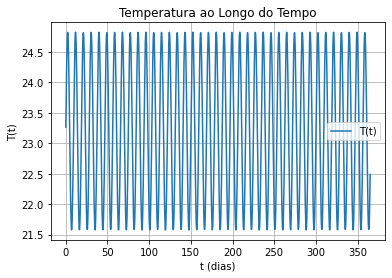

In [4]:
# Pontos no tempo
t_values = np.linspace(0, 365, 1000) # 1000 pontos entre 0 e 365
T_values = [T(t) for t in t_values]

# Plotando
plt.plot(t_values, T_values, label='T(t)')
plt.title('Temperatura ao Longo do Tempo')
plt.xlabel('t (dias)')
plt.ylabel('T(t)')
plt.legend()
plt.grid(True)
plt.show()

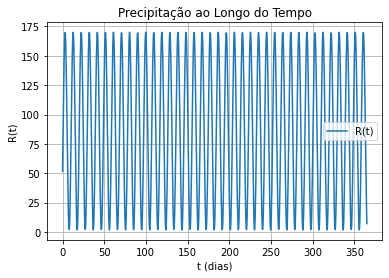

In [5]:
# Pontos no tempo
t_values = np.linspace(0, 365, 1000) # 1000 pontos entre 0 e 365
R_values = [R(t) for t in t_values]

# Plotando
plt.plot(t_values, R_values, label='R(t)')
plt.title('Precipitação ao Longo do Tempo')
plt.xlabel('t (dias)')
plt.ylabel('R(t)')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
def modelo_original(t, z, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, I_M0, I_H0):
    
    S_H, I_H, R_H, S_M, E_M, I_M = z
    
    # Funções de temperatura e chuva
    def Temp(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def Rain(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    R_curr = Rain(t)
    T_curr = Temp(t)
    
    # Duração da fase de desenvolvimento das larvas
    def tau_L(Temp):
        return 1 / (c1 * Temp + c2)
    
    # Taxa diária de sobrevivência dos mosquitos
    def p(Temp):
        return np.exp(-1 / (A*Temp**2 + B*Temp + C))
    
    # Probabilidade de sobrevivência das larvas dependente de temperatura e chuva
    def p_LT(Temp):
        return np.exp(-(c1 * Temp + c2))
    
    def p_LR(Rain):
        return (4*p_ML/R_L**2) * Rain * (R_L - Rain)
    
    def p_LRT(Rain,Temp):
        return p_LR(Rain)*p_LT(Temp)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva
    def p_ER(Rain):
        return (4*p_ME/R_L**2) * Rain * (R_L - Rain)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva 
    def p_PR(Rain):
        return (4*p_MP/R_L**2) * Rain * (R_L - Rain)

    # Duração do ciclo esporogônico
    def tau_M(Temp):
        return DD / (Temp - Tmin)
    
    tau_M_curr = tau_M(T_curr)

    # Definindo a função de sobrevivência do mosquito
    def l_tau_M(tau_M, Temp):  
        p_T = p(Temp)
        return p_T**tau_M
    
    l_curr = l_tau_M(tau_M_curr, T_curr)

    # Definindo a taxa de mortalidade do mosquito
    def mu(Temp):
        return -log(p(Temp))
    
    mu_curr = mu(T_curr)
    
    # Calcula a taxa de mordida e probabilidade de transmissão
    def a(Temp):
        return (T_curr - T1) / D1
    
    a_curr = a(T_curr)
    
    def b(Rain,Temp):
        return B_E * p_ER(R_curr) * p_LRT(R_curr,T_curr) * p_PR(R_curr) / (tau_E + tau_L(T_curr) + tau_P)
    
    b_curr = b(R_curr, T_curr)
    
    dShdt = -a_curr * b2 * (I_M0 / N) * S_H
    dIhdt = a_curr * b2 * (I_M0 / N) * S_H - gamma * I_H
    dRhdt = gamma * I_H
    
    dSmdt = b_curr - a_curr * b1 * (I_H0 / N) * S_M - mu_curr * S_M
    dEmdt = a_curr * b1 * (I_H0 / N) * S_M - mu_curr * E_M - a_curr * b1 * (I_H0 / N) * S_M * l_curr
    dImdt = a_curr * b1 * (I_H0 / N) * S_M * l_curr - mu_curr * I_M
    
    return [dShdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt] 

In [7]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

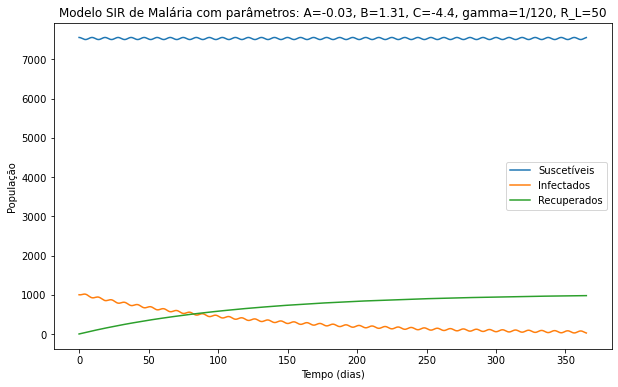

In [8]:
t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(modelo_original, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title(f'Modelo SIR de Malária com parâmetros: A={round(A, 2)}, B={round(B, 2)}, C={round(C, 2)}, gamma={gamma}, R_L={R_L}')

plt.legend()

plt.show()

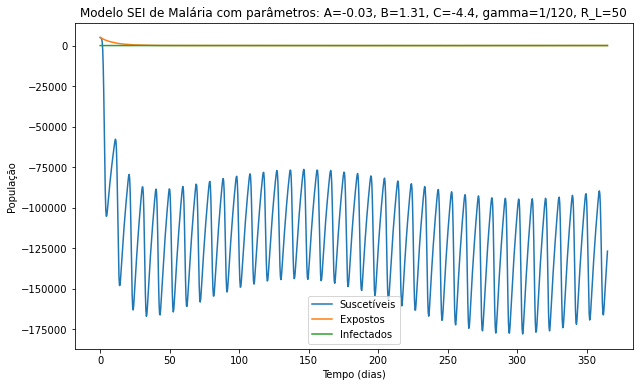

In [9]:
t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(modelo_original, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title(f'Modelo SEI de Malária com parâmetros: A={round(A, 2)}, B={round(B, 2)}, C={round(C, 2)}, gamma={gamma}, R_L={R_L}')

plt.legend()

plt.show()

## 2

#### Corrigindo a temperatura e chuva para utilizar dados anuais de Manaus:

In [10]:
T1= 26.4 
T2= 0.025
omega1= 0.017
phi1= -1.45

R1= 250.083 
R2= 0.565
omega2= 0.02
phi2=1.6

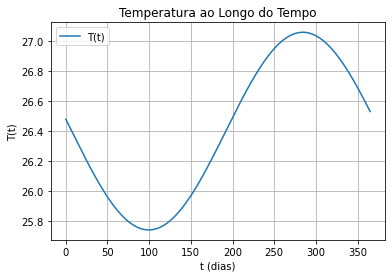

In [11]:
# Pontos no tempo
t_values = np.linspace(0, 365, 1000) # 1000 pontos entre 0 e 365
T_values = [T(t) for t in t_values]

# Plotando
plt.plot(t_values, T_values, label='T(t)')
plt.title('Temperatura ao Longo do Tempo')
plt.xlabel('t (dias)')
plt.ylabel('T(t)')
plt.legend()
plt.grid(True)
plt.show()

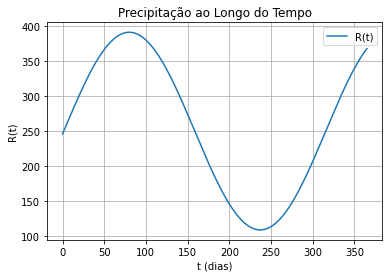

In [12]:
# Pontos no tempo
t_values = np.linspace(0, 365, 1000) # 1000 pontos entre 0 e 365
R_values = [R(t) for t in t_values]

# Plotando
plt.plot(t_values, R_values, label='R(t)')
plt.title('Precipitação ao Longo do Tempo')
plt.xlabel('t (dias)')
plt.ylabel('R(t)')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

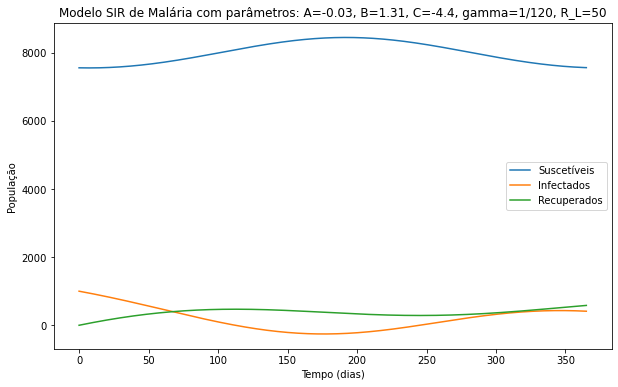

In [14]:
t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(modelo_original, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title(f'Modelo SIR de Malária com parâmetros: A={round(A, 2)}, B={round(B, 2)}, C={round(C, 2)}, gamma={gamma}, R_L={R_L}')

plt.legend()

plt.show()

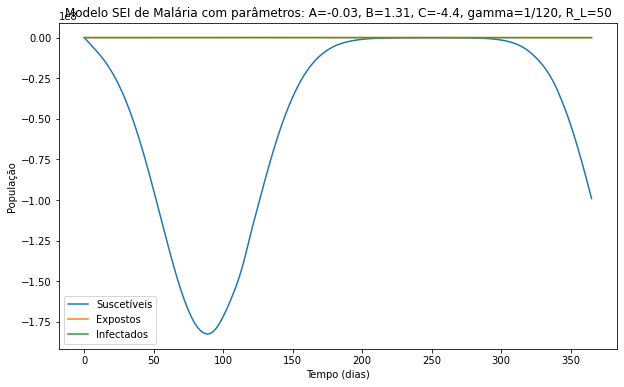

In [15]:
t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(modelo_original, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title(f'Modelo SEI de Malária com parâmetros: A={round(A, 2)}, B={round(B, 2)}, C={round(C, 2)}, gamma={gamma}, R_L={R_L}')

plt.legend()

plt.show()

## 3

#### Aumentando $R_L$:

In [16]:
R_L=450

In [17]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

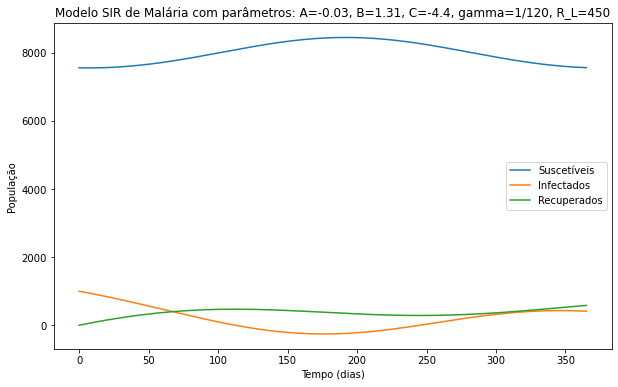

In [18]:
t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(modelo_original, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title(f'Modelo SIR de Malária com parâmetros: A={round(A, 2)}, B={round(B, 2)}, C={round(C, 2)}, gamma={gamma}, R_L={R_L}')

plt.legend()

plt.show()

In [19]:
min(I_H)

-255.73129365372304

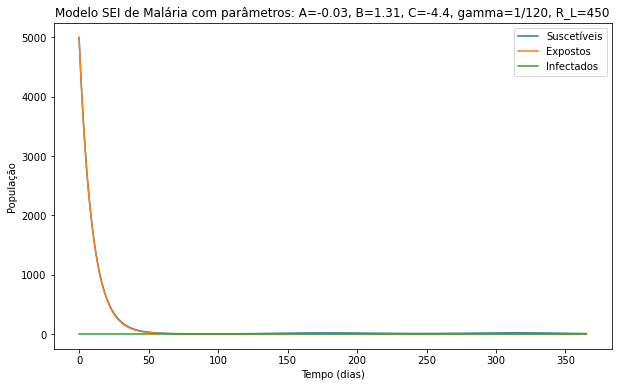

In [20]:
t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(modelo_original, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title(f'Modelo SEI de Malária com parâmetros: A={round(A, 2)}, B={round(B, 2)}, C={round(C, 2)}, gamma={gamma}, R_L={R_L}')

plt.legend()

plt.show()

## 4

#### Modificando $A, \ B$ e $C$

In [21]:
A=317.925
B=15
C=-48.78

In [22]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

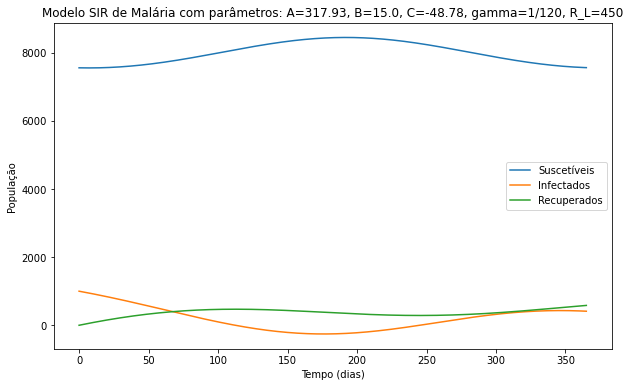

In [23]:
t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(modelo_original, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title(f'Modelo SIR de Malária com parâmetros: A={round(A, 2)}, B={round(B, 2)}, C={round(C, 2)}, gamma={gamma}, R_L={R_L}')

plt.legend()

plt.show()

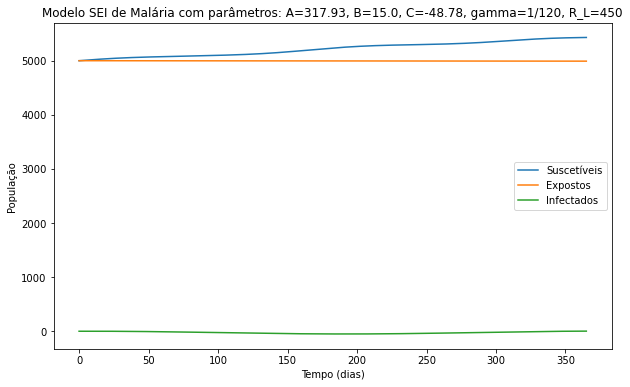

In [24]:
t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(modelo_original, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title(f'Modelo SEI de Malária com parâmetros: A={round(A, 2)}, B={round(B, 2)}, C={round(C, 2)}, gamma={gamma}, R_L={R_L}')

plt.legend()

plt.show()

## 5

#### Aumentando as probabilidades de sobrevivência:

In [25]:
p_ME=0.9
p_ML=0.75
p_MP=0.85

In [26]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

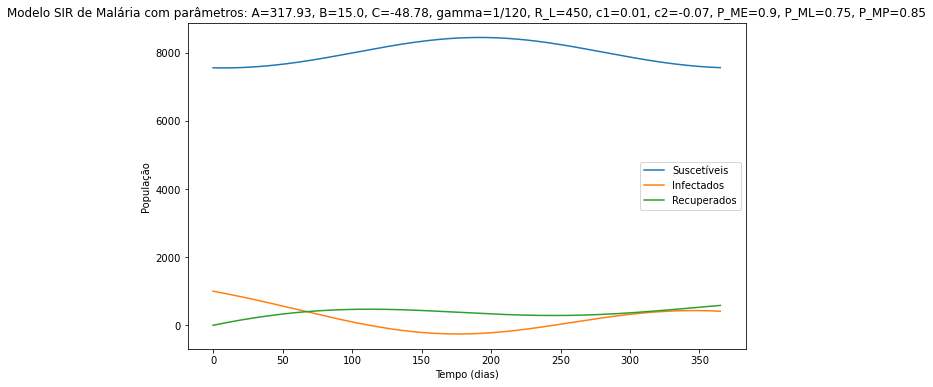

In [27]:
t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(modelo_original, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title(f'Modelo SIR de Malária com parâmetros: A={round(A, 2)}, B={round(B, 2)}, C={round(C, 2)}, gamma={gamma}, R_L={R_L}, c1={round(c1, 2)}, c2={round(c2, 2)}, P_ME={round(p_ME, 2)}, P_ML={round(p_ML, 2)}, P_MP={round(p_MP, 2)}')

plt.legend()

plt.show()

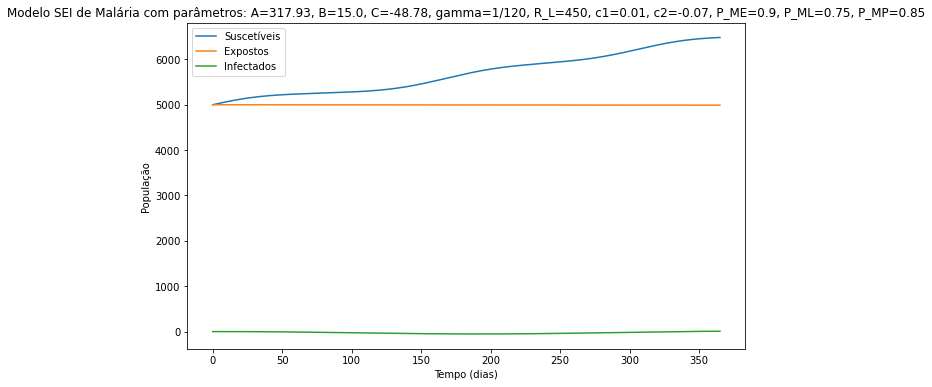

In [28]:
t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(modelo_original, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title(f'Modelo SEI de Malária com parâmetros: A={round(A, 2)}, B={round(B, 2)}, C={round(C, 2)}, gamma={gamma}, R_L={R_L}, c1={round(c1, 2)}, c2={round(c2, 2)}, P_ME={round(p_ME, 2)}, P_ML={round(p_ML, 2)}, P_MP={round(p_MP, 2)}')

plt.legend()

plt.show()

## 6

#### Aumentando o número de mosquitos e inicialmente expostos:

In [29]:
M=300000 #10000
E_M0=50000
I_M0=0
S_M0=M-E_M0-I_M0

In [30]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

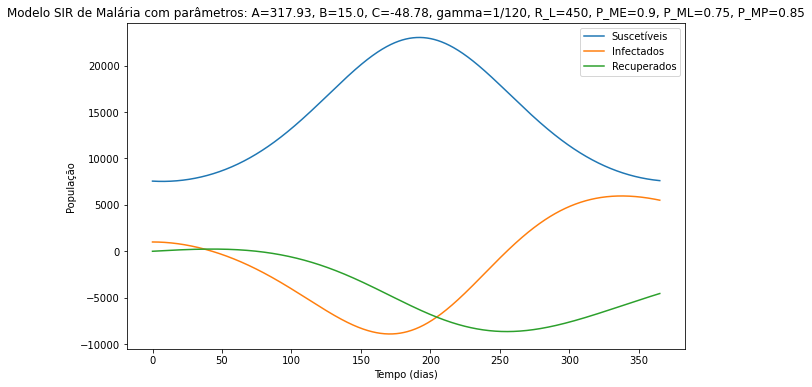

In [31]:
t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(modelo_original, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title(f'Modelo SIR de Malária com parâmetros: A={round(A, 2)}, B={round(B, 2)}, C={round(C, 2)}, gamma={gamma}, R_L={R_L}, P_ME={round(p_ME, 2)}, P_ML={round(p_ML, 2)}, P_MP={round(p_MP, 2)}')

plt.legend()

plt.show()

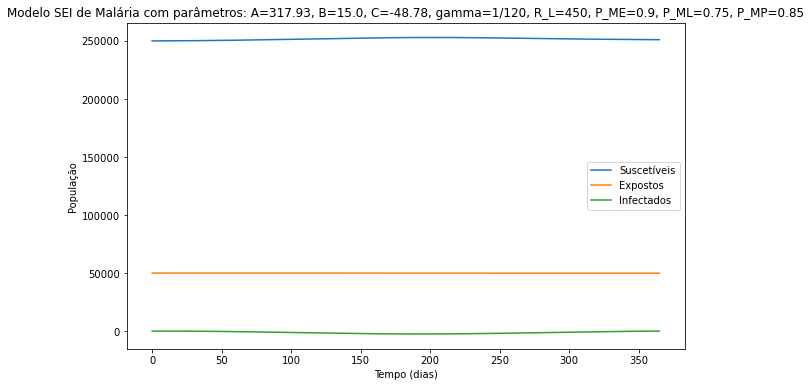

In [32]:
t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(modelo_original, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title(f'Modelo SEI de Malária com parâmetros: A={round(A, 2)}, B={round(B, 2)}, C={round(C, 2)}, gamma={gamma}, R_L={R_L}, P_ME={round(p_ME, 2)}, P_ML={round(p_ML, 2)}, P_MP={round(p_MP, 2)}')

plt.legend()

plt.show()

## 7

#### Diminuindo $\gamma$ e incluindo $b_3$ na modelagem SEI:

In [33]:
gamma=1/1825

In [34]:
def modelo_taxa_infeccao_expostos(t, z, T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0):
    
    S_H, I_H, R_H, S_M, E_M, I_M = z
    
    # Funções de temperatura e chuva
    def Temp(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def Rain(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    R_curr = Rain(t)
    T_curr = Temp(t)
    
    # Duração da fase de desenvolvimento das larvas
    def tau_L(Temp):
        return 1 / (c1 * Temp + c2)
    
    # Taxa diária de sobrevivência dos mosquitos
    def p(Temp):
        return np.exp(-1 / (A*Temp**2 + B*Temp + C))
    
    # Probabilidade de sobrevivência das larvas dependente de temperatura e chuva
    def p_LT(Temp):
        return np.exp(-(c1 * Temp + c2))
    
    def p_LR(Rain):
        return (4*p_ML/R_L**2) * Rain * (R_L - Rain)
    
    def p_LRT(Rain,Temp):
        return p_LR(Rain)*p_LT(Temp)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva 
    def p_ER(Rain):
        return (4*p_ME/R_L**2) * Rain * (R_L - Rain)
    
    def p_PR(Rain):
        return (4*p_MP/R_L**2) * Rain * (R_L - Rain)

    # Duração do ciclo esporogônico
    def tau_M(Temp):
        return DD / (Temp - Tmin)
    
    tau_M_curr = tau_M(T_curr)

    # Taxa de infecção de expostos (1/Duração do ciclo esporogônico)
    def b3(tau_M, Temp):
        return 1/tau_M
    
    b3_curr = b3(tau_M_curr, T_curr)
    
    # Definindo a função de sobrevivência do mosquito
    def l_tau_M(tau_M, Temp):  
        p_T = p(Temp)
        return p_T**tau_M
    
    l_curr = l_tau_M(tau_M_curr, T_curr)

    # Definindo a taxa de mortalidade do mosquito
    def mu(Temp):
        return -log(p(Temp))
    
    mu_curr = mu(T_curr)
    
    # Calcula a taxa de mordida e taxa de nascimento
    def a(Temp):
        return (T_linha - T_curr) / D1
    
    a_curr = a(T_curr)
    
    def b(Rain,Temp):
        return B_E * p_ER(R_curr) * p_LRT(R_curr,T_curr) * p_PR(R_curr) / (tau_E + tau_L(T_curr) + tau_P)
    
    b_curr = b(R_curr, T_curr)
    
    dShdt = -a_curr * b2 * (I_M / N) * S_H
    dIhdt = a_curr * b2 * (I_M / N) * S_H - gamma * I_H
    dRhdt = gamma * I_H
    
    dSmdt = b_curr - a_curr * b1 * (I_H / N) * S_M - mu_curr * S_M
    dEmdt = a_curr * b1 * (I_H / N) * S_M - mu_curr * E_M - b3_curr * E_M * l_curr
    dImdt = b3_curr * E_M * l_curr - mu_curr * I_M
    
    return [dShdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt] 

In [35]:
T_linha = 26.4

S_H0 = N - I_H0
S_M0 = M - E_M0 - I_M0

In [36]:
args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

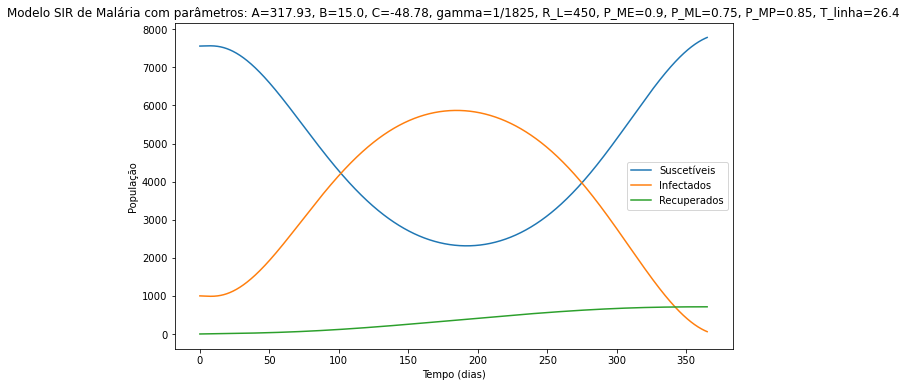

In [37]:
t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(modelo_taxa_infeccao_expostos, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title(f'Modelo SIR de Malária com parâmetros: A={round(A, 2)}, B={round(B, 2)}, C={round(C, 2)}, gamma={gamma}, R_L={R_L}, P_ME={round(p_ME, 2)}, P_ML={round(p_ML, 2)}, P_MP={round(p_MP, 2)}, T_linha={round(T_linha, 2)}')

plt.legend()

plt.show()

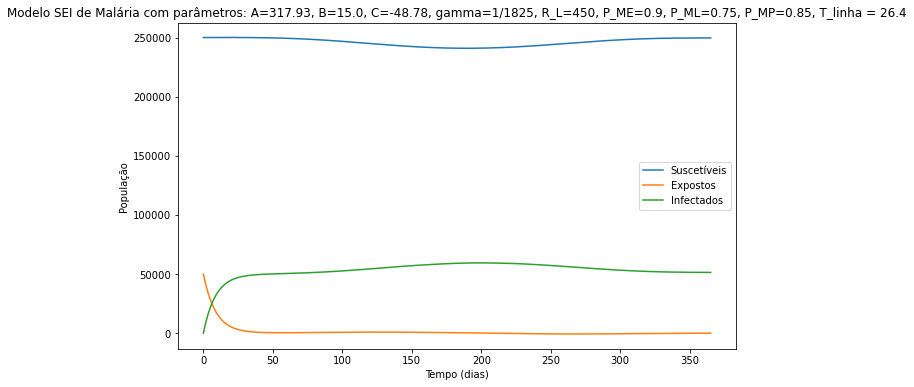

In [38]:
t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(modelo_taxa_infeccao_expostos, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title(f'Modelo SEI de Malária com parâmetros: A={round(A, 2)}, B={round(B, 2)}, C={round(C, 2)}, gamma={gamma}, R_L={R_L}, P_ME={round(p_ME, 2)}, P_ML={round(p_ML, 2)}, P_MP={round(p_MP, 2)}, T_linha = {round(T_linha, 2)}')

plt.legend()

plt.show()

## 8

#### Fazendo adaptações necessárias a $l$:

In [39]:
def modelo_correcao_b3(t, z, T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0):
    
    S_H, I_H, R_H, S_M, E_M, I_M = z
    
    # Funções de temperatura e chuva
    def Temp(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def Rain(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    R_curr = Rain(t)
    T_curr = Temp(t)
    
    # Duração da fase de desenvolvimento das larvas
    def tau_L(Temp):
        return 1 / (c1 * Temp + c2)
    
    # Taxa diária de sobrevivência dos mosquitos
    def p(Temp):
        return np.exp(-1 / (A*Temp**2 + B*Temp + C))
    
    # Probabilidade de sobrevivência das larvas dependente de temperatura e chuva
    def p_LT(Temp):
        return np.exp(-(c1 * Temp + c2))
    
    def p_LR(Rain):
        return (4*p_ML/R_L**2) * Rain * (max(10^-5,R_L - Rain))
    
    def p_LRT(Rain,Temp):
        return p_LR(Rain)*p_LT(Temp)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva
    def p_ER(Rain):
        return (4*p_ME/R_L**2) * Rain * (max(10^-5,R_L - Rain))
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva 
    def p_PR(Rain):
        return (4*p_MP/R_L**2) * Rain * (max(10^-5,R_L - Rain))

    # Duração do ciclo esporogônico
    def tau_M(Temp):
        return DD / (max(10^-5,Temp - Tmin))
    
    tau_M_curr = tau_M(T_curr)

    # Taxa de infecção de expostos (1/Duração do ciclo esporogônico)
    def b3(tau_M, Temp):
        return 1/tau_M
    
    b3_curr = b3(tau_M_curr, T_curr)
    
    # Definindo a função de sobrevivência do mosquito
    def l_tau_M(tau_M, Temp):  
        p_T = p(Temp)
        return p_T**tau_M
    
    l_curr = l_tau_M(tau_M_curr, T_curr)

    # Definindo a taxa de mortalidade do mosquito
    def mu(Temp):
        return -log(p(Temp))
    
    mu_curr = mu(T_curr)
    
    # Calcula a taxa de picada e probabilidade de transmissão
    def a(Temp):
        return (max(10^-5, Temp - T_linha)) / D1
    
    a_curr = a(T_curr)
    
    def b(Rain,Temp):
        return B_E * p_ER(Rain) * p_LRT(Rain,Temp) * p_PR(Rain) / (tau_E + tau_L(Temp) + tau_P)
    
    b_curr = b(R_curr, T_curr)
    
    dShdt = -a_curr * b2 * (I_M / N) * S_H
    dIhdt = a_curr * b2 * (I_M / N) * S_H - gamma * I_H
    dRhdt = gamma * I_H
    
    dSmdt = b_curr - a_curr * b1 * (I_H / N) * S_M - mu_curr * S_M
    dEmdt = a_curr * b1 * (I_H / N) * S_M - mu_curr * E_M - b3_curr * E_M - l_curr * E_M
    dImdt = b3_curr * E_M - mu_curr * I_M
    
    return [dShdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt]

In [40]:
T_linha = 24.4

In [41]:
args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

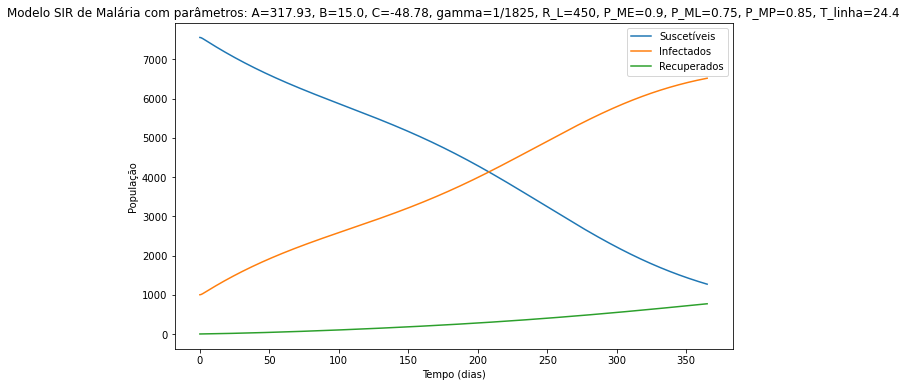

In [42]:
t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(modelo_correcao_b3, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title(f'Modelo SIR de Malária com parâmetros: A={round(A, 2)}, B={round(B, 2)}, C={round(C, 2)}, gamma={gamma}, R_L={R_L}, P_ME={round(p_ME, 2)}, P_ML={round(p_ML, 2)}, P_MP={round(p_MP, 2)}, T_linha={round(T_linha, 2)}')

plt.legend()

plt.show()

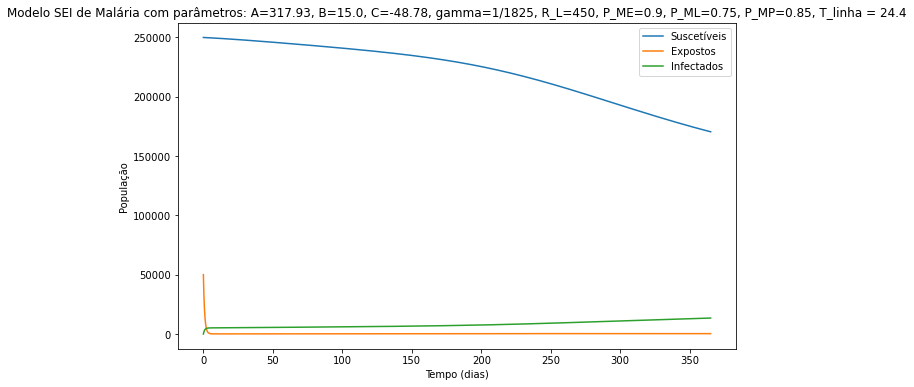

In [43]:
t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(modelo_correcao_b3, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title(f'Modelo SEI de Malária com parâmetros: A={round(A, 2)}, B={round(B, 2)}, C={round(C, 2)}, gamma={gamma}, R_L={R_L}, P_ME={round(p_ME, 2)}, P_ML={round(p_ML, 2)}, P_MP={round(p_MP, 2)}, T_linha = {round(T_linha, 2)}')

plt.legend()

plt.show()

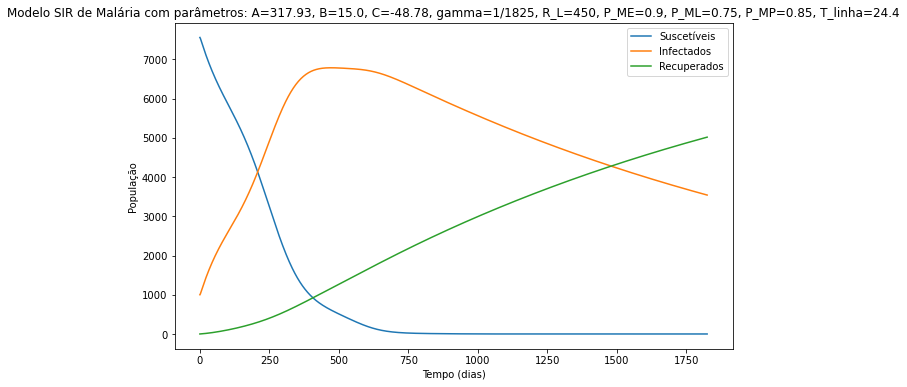

In [44]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(modelo_correcao_b3, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title(f'Modelo SIR de Malária com parâmetros: A={round(A, 2)}, B={round(B, 2)}, C={round(C, 2)}, gamma={gamma}, R_L={R_L}, P_ME={round(p_ME, 2)}, P_ML={round(p_ML, 2)}, P_MP={round(p_MP, 2)}, T_linha={round(T_linha, 2)}')

plt.legend()

plt.show()

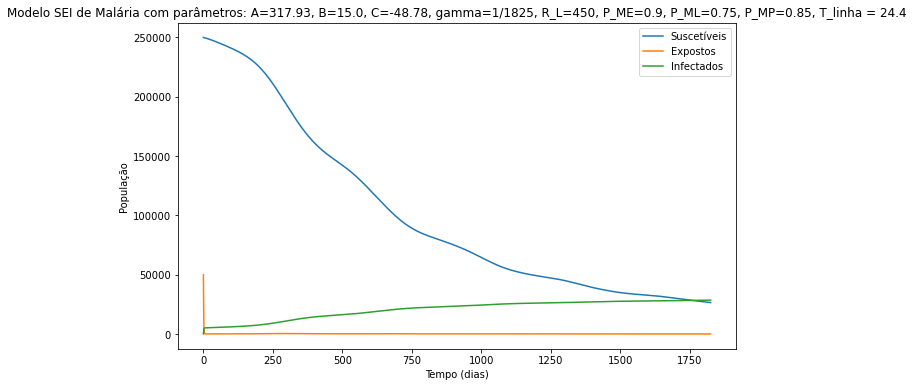

In [45]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(modelo_correcao_b3, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title(f'Modelo SEI de Malária com parâmetros: A={round(A, 2)}, B={round(B, 2)}, C={round(C, 2)}, gamma={gamma}, R_L={R_L}, P_ME={round(p_ME, 2)}, P_ML={round(p_ML, 2)}, P_MP={round(p_MP, 2)}, T_linha = {round(T_linha, 2)}')

plt.legend()

plt.show()

## 9

#### Diminuindo $\gamma$ para encurtar o período de infecção

In [46]:
gamma=1/120

In [47]:
args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

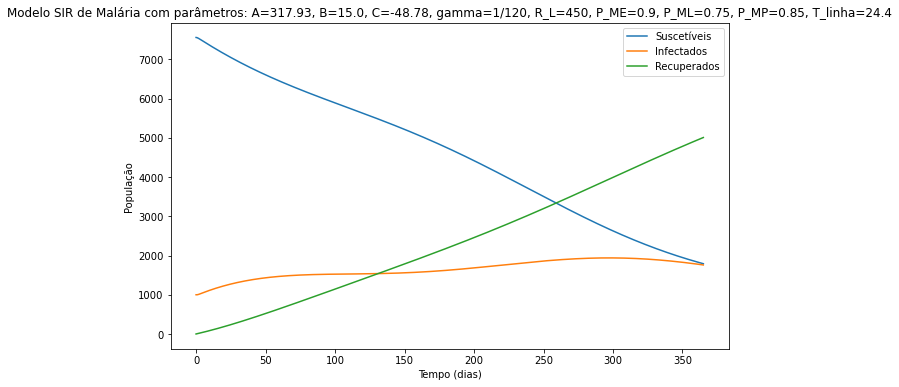

In [48]:
t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(modelo_correcao_b3, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title(f'Modelo SIR de Malária com parâmetros: A={round(A, 2)}, B={round(B, 2)}, C={round(C, 2)}, gamma={gamma}, R_L={R_L}, P_ME={round(p_ME, 2)}, P_ML={round(p_ML, 2)}, P_MP={round(p_MP, 2)}, T_linha={round(T_linha, 2)}')

plt.legend()

plt.show()

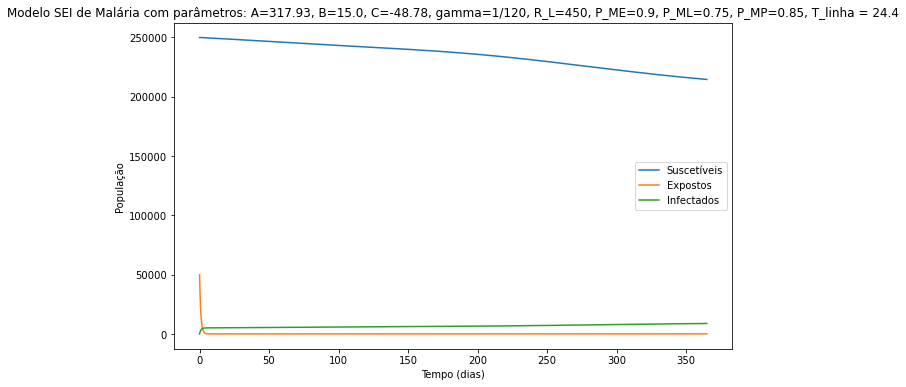

In [49]:
t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(modelo_correcao_b3, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title(f'Modelo SEI de Malária com parâmetros: A={round(A, 2)}, B={round(B, 2)}, C={round(C, 2)}, gamma={gamma}, R_L={R_L}, P_ME={round(p_ME, 2)}, P_ML={round(p_ML, 2)}, P_MP={round(p_MP, 2)}, T_linha = {round(T_linha, 2)}')

plt.legend()

plt.show()

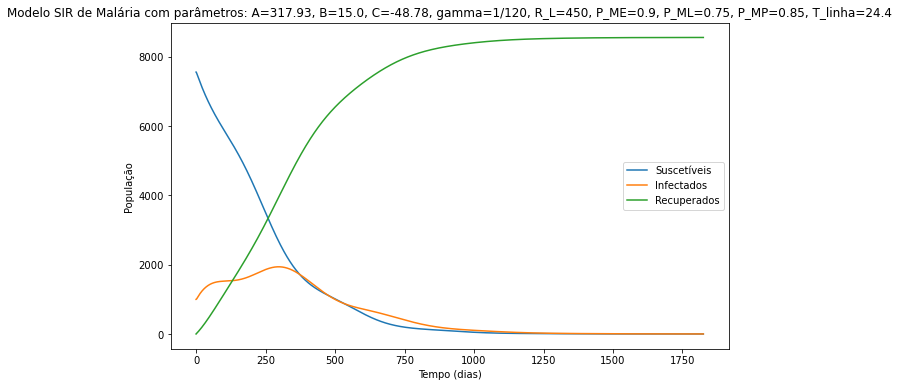

In [50]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(modelo_correcao_b3, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title(f'Modelo SIR de Malária com parâmetros: A={round(A, 2)}, B={round(B, 2)}, C={round(C, 2)}, gamma={gamma}, R_L={R_L}, P_ME={round(p_ME, 2)}, P_ML={round(p_ML, 2)}, P_MP={round(p_MP, 2)}, T_linha={round(T_linha, 2)}')

plt.legend()

plt.show()

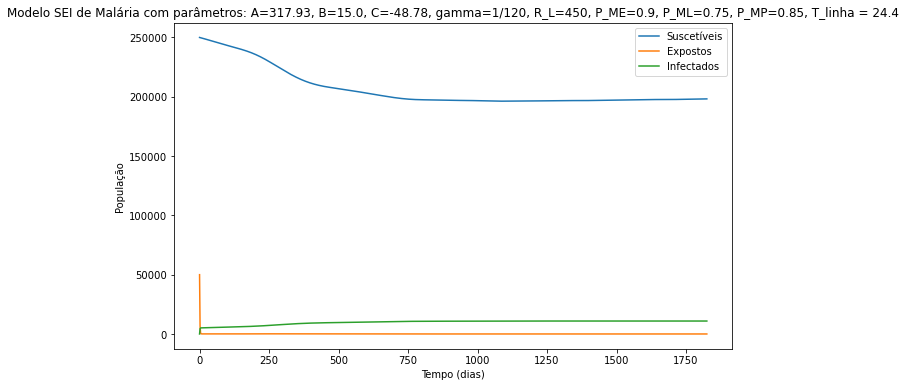

In [51]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(modelo_correcao_b3, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title(f'Modelo SEI de Malária com parâmetros: A={round(A, 2)}, B={round(B, 2)}, C={round(C, 2)}, gamma={gamma}, R_L={R_L}, P_ME={round(p_ME, 2)}, P_ML={round(p_ML, 2)}, P_MP={round(p_MP, 2)}, T_linha = {round(T_linha, 2)}')

plt.legend()

plt.show()

## 10

#### Testando com um único infectado para humanos e mosquitos respectivamente

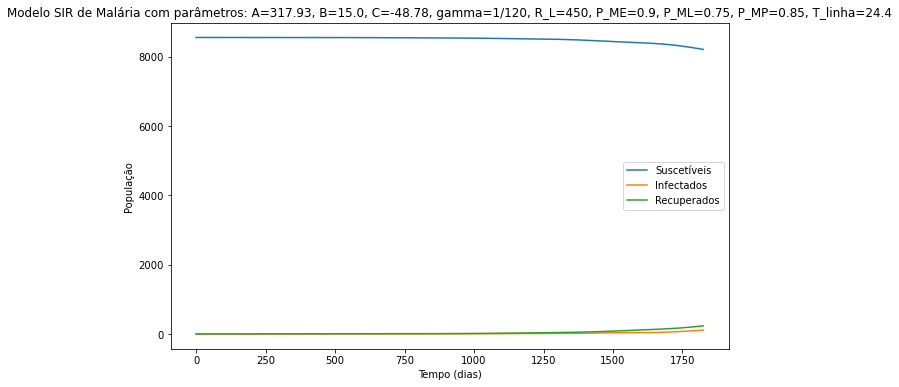

In [52]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(modelo_correcao_b3, [0, 1825], [N-1, 1, 0, M-1, 1, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title(f'Modelo SIR de Malária com parâmetros: A={round(A, 2)}, B={round(B, 2)}, C={round(C, 2)}, gamma={gamma}, R_L={R_L}, P_ME={round(p_ME, 2)}, P_ML={round(p_ML, 2)}, P_MP={round(p_MP, 2)}, T_linha={round(T_linha, 2)}')

plt.legend()

plt.show()

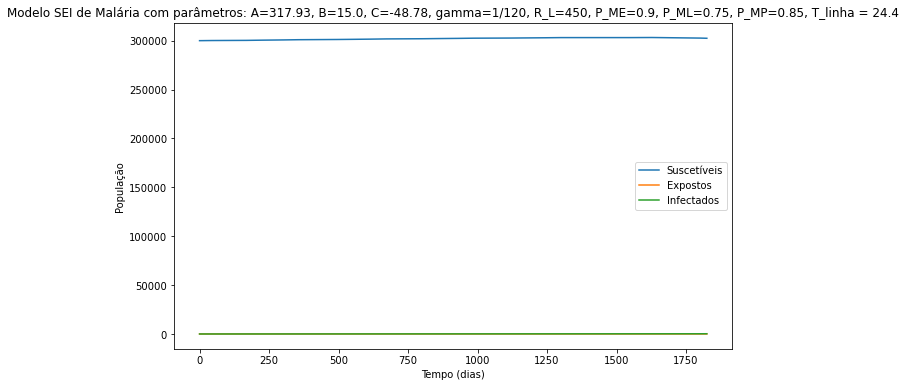

In [53]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(modelo_correcao_b3, [0, 1825], [N-1, 1, 0, M-1, 1, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title(f'Modelo SEI de Malária com parâmetros: A={round(A, 2)}, B={round(B, 2)}, C={round(C, 2)}, gamma={gamma}, R_L={R_L}, P_ME={round(p_ME, 2)}, P_ML={round(p_ML, 2)}, P_MP={round(p_MP, 2)}, T_linha = {round(T_linha, 2)}')

plt.legend()

plt.show()

## 11

#### Cálculo de $\mathcal{R}_0$

$\mathcal{R}_0$ do SIR:

$$\Big | \dfrac{ab_2}{\gamma}\Big |$$

$\mathcal{R}_0$ do SEI:

$$\Big | \dfrac{ab_1b_3}{(b_3+l+ \mu)\mu}\Big |$$

$\mathcal{R}_0$ do SIR/SEI:

$$\Big | \sqrt{\dfrac{a^2 b_1 b_2 b_3}{(b_3 +  l + \mu) \gamma \mu}}\Big |$$

In [54]:
def R0_sir(a, b2, gamma):
    return abs((a * b2) / gamma)
    
#R0_sir_curr = R0_sir(a_curr, b2, gamma)
    
def R0_sei(a, b1, b3, l, mu):
    return abs((a * b1 * b3) / ((b3 + l) * mu + mu** 2))
    
#R0_sei_curr = R0_sei(a_curr, b1, b3_curr, l_curr, mu_curr)
    
def R0_full(a, b1, b2, b3, gamma, l, mu):
    return abs(((a** 2 * b1 * b2 * b3) / (b3 * gamma * mu + gamma * l * mu + gamma * mu** 2))**(1/2))
    
#R0_curr = R0(a_curr, b1, b2, b3_curr, gamma, l_curr, mu_curr)

In [55]:
def calculate_initial_values(R_L, T_linha, Tmin, DD, D1, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                            p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, gamma):
    
    T0 = T1 * (1 + T2 * cos(omega1 * 0 - phi1))
    R0 = R1 * (1 + R2 * cos(omega2 * 0 - phi2))

    tau_L0 = 1 / (c1 * T0 + c2)

    p_LT0 = np.exp(-(c1 * T0 + c2))
    
    p_LR0 = (4 * p_ML / R_L**2) * R0 * (max(1e-5, R_L - R0))
    
    p_LRT0 = p_LR0 * p_LT0
    
    p_ER0 = (4 * p_ME / R_L**2) * R0 * (max(1e-5, R_L - R0))
    
    p_PR0 = (4 * p_MP / R_L**2) * R0 * (max(1e-5, R_L - R0))

    a0 = (max(1e-5, T0 - T_linha)) / D1
    b0 = B_E * p_ER0 * p_LRT0 * p_PR0 / (tau_E + tau_L0 + tau_P)

    tau_M0 = DD / (max(1e-5, T0 - Tmin))
    
    b30 =  1 / tau_M0
    
    p0 = np.exp(-1 / (A * T0**2 + B * T0 + C))
    l0 = p0 ** tau_M0

    mu0 = -log(p0)

    initial_R0_sir = R0_sir(a0, b2, gamma)
    initial_R0_sei = R0_sei(a0, b1, b30, l0, mu0)
    initial_R0_full = R0_full(a0, b1, b2, b30, gamma, l0, mu0)
    
    return initial_R0_sir, initial_R0_sei, initial_R0_full, a0

In [56]:
initial_R0_sir, initial_R0_sei, initial_R0_full, a0 = calculate_initial_values(R_L, T_linha, Tmin, DD, D1, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, gamma)

In [57]:
print(f'R0_sir = {initial_R0_sir} \nR0_sei = {initial_R0_sei}\nR0_acoplado = {initial_R0_full}\nTaxa de picadas = {a0}')

R0_sir = 0.6153135271246742 
R0_sei = 52.10744324365842
R0_acoplado = 5.6623682935415145
Taxa de picadas = 0.05697347473376614


## 12

#### Diminuindo $A$

In [58]:
A=15

In [59]:
initial_R0_sir, initial_R0_sei, initial_R0_full, a0 = calculate_initial_values(R_L, T_linha, Tmin, DD, D1, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, gamma)

print(f'R0_sir = {initial_R0_sir} \nR0_sei = {initial_R0_sei}\nR0_acoplado = {initial_R0_full}\nTaxa de picadas = {a0}')

R0_sir = 0.6153135271246742 
R0_sei = 2.53750429527791
R0_acoplado = 1.2495442041086269
Taxa de picadas = 0.05697347473376614


In [60]:
A=12.5

## 13

#### Aumentando $T'$

In [61]:
T_linha

24.4000000000000

In [62]:
T_linha=25.6

In [63]:
initial_R0_sir, initial_R0_sei, initial_R0_full, a0 = calculate_initial_values(R_L, T_linha, Tmin, DD, D1, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, gamma)

print(f'R0_sir = {initial_R0_sir} \nR0_sei = {initial_R0_sei}\nR0_acoplado = {initial_R0_full}\nTaxa de picadas = {a0}')

R0_sir = 0.26024503397398857 
R0_sei = 0.9002047882569278
R0_acoplado = 0.48401841463261647
Taxa de picadas = 0.02409676240499894


In [64]:
args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

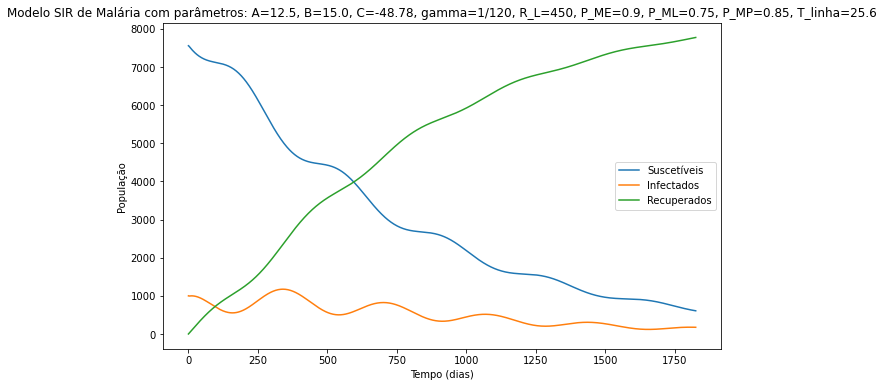

In [65]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(modelo_correcao_b3, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title(f'Modelo SIR de Malária com parâmetros: A={round(A, 2)}, B={round(B, 2)}, C={round(C, 2)}, gamma={gamma}, R_L={R_L}, P_ME={round(p_ME, 2)}, P_ML={round(p_ML, 2)}, P_MP={round(p_MP, 2)}, T_linha={round(T_linha, 2)}')

plt.legend()

plt.show()

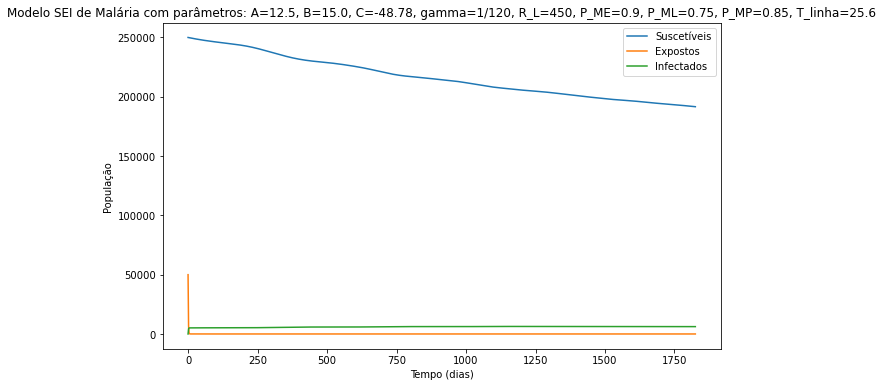

In [66]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(modelo_correcao_b3, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title(f'Modelo SEI de Malária com parâmetros: A={round(A, 2)}, B={round(B, 2)}, C={round(C, 2)}, gamma={gamma}, R_L={R_L}, P_ME={round(p_ME, 2)}, P_ML={round(p_ML, 2)}, P_MP={round(p_MP, 2)}, T_linha={round(T_linha, 2)}')

plt.legend()

plt.show()

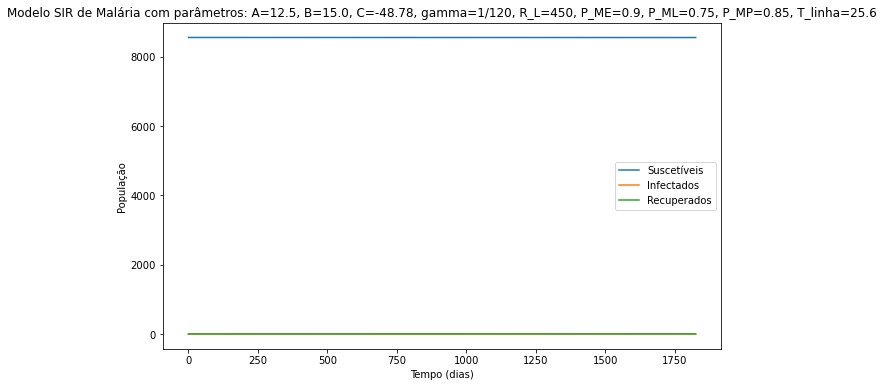

In [67]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(modelo_correcao_b3, [0, 1825], [N-1, 1, 0, M-1, 1, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title(f'Modelo SIR de Malária com parâmetros: A={round(A, 2)}, B={round(B, 2)}, C={round(C, 2)}, gamma={gamma}, R_L={R_L}, P_ME={round(p_ME, 2)}, P_ML={round(p_ML, 2)}, P_MP={round(p_MP, 2)}, T_linha={round(T_linha, 2)}')

plt.legend()

plt.show()

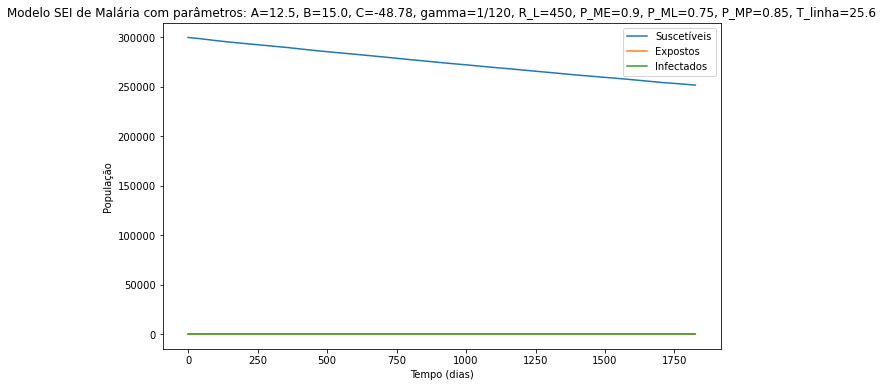

In [68]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(modelo_correcao_b3, [0, 1825], [N-1, 1, 0, M-1, 1, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title(f'Modelo SEI de Malária com parâmetros: A={round(A, 2)}, B={round(B, 2)}, C={round(C, 2)}, gamma={gamma}, R_L={R_L}, P_ME={round(p_ME, 2)}, P_ML={round(p_ML, 2)}, P_MP={round(p_MP, 2)}, T_linha={round(T_linha, 2)}')

plt.legend()

plt.show()

## 14

#### Calculando $\mathcal{R}_0$ das análises em 1 (dados originais de Parham e Michael):

In [69]:
T1=23.2
T2=0.07
omega1=0.67
phi1=1.53

R1=85.9
R2=0.98
omega2=0.65
phi2=1.99

B_E=200
p_ME=0.9
p_ML=0.25
p_MP=0.75
tau_E=1
tau_P=1
c1=0.00554
c2=-0.06737
D1=36.5
b1=0.04
A=-0.03
B=1.31
C=-4.4
b2=0.09
tau_H=10
DD=105
Tmin=14.5
gamma= 1/120
R_L = 50
N=8558
M= 10000  #0
E_M0=5000 #0 # None
I_H0=1000 
if E_M0 is None:
        E_M0 = M / 100

S_H0 = N - I_H0
S_M0 = M - E_M0

#### Com os parâmetros originais, usei T_linha = T1

In [70]:
initial_R0_sir, initial_R0_sei, initial_R0_full, a0 = calculate_initial_values(R_L, T1, Tmin, DD, D1, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, gamma)

print(f'R0_sir = {initial_R0_sir} \nR0_sei = {initial_R0_sei}\nR0_acoplado = {initial_R0_full}\nTaxa de picadas = {a0}')

R0_sir = 0.01959825942927436 
R0_sei = 0.00012392848185565277
R0_acoplado = 0.0015584551767963053
Taxa de picadas = 0.001814653650858737


#### Calculando $\mathcal{R}_0$ das análises em 9 a 13:

#### 9:

In [71]:
T1= 26.4 
T2= 0.025
omega1= 0.017
phi1= -1.45

R1= 250.083 
R2= 0.565
omega2= 0.02
phi2=1.6

B_E=200

p_ME=0.9
p_ML=0.75
p_MP=0.85

tau_E=1
tau_P=1
c1=0.00554
c2=-0.06737
D1=36.5
b1=0.04
b2=0.09

A=317.925
B=15
C=-48.78

tau_H=10
DD=105
Tmin=14.5
gamma= 1/120
R_L = 450
N=8558
M=300000 #10000
E_M0=50000
I_M0=0

if E_M0 is None:
        E_M0 = M / 100

S_H0 = N - I_H0
S_M0 = M - E_M0 - I_M0

In [72]:
initial_R0_sir, initial_R0_sei, initial_R0_full, a0 = calculate_initial_values(R_L, T_linha, Tmin, DD, D1, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, gamma)

print(f'R0_sir = {initial_R0_sir} \nR0_sei = {initial_R0_sei}\nR0_acoplado = {initial_R0_full}\nTaxa de picadas = {a0}')

R0_sir = 0.26024503397398857 
R0_sei = 22.03868879758255
R0_acoplado = 2.3948818999835946
Taxa de picadas = 0.02409676240499894


#### 10:

In [73]:
T1= 26.4 
T2= 0.025
omega1= 0.017
phi1= -1.45

R1= 250.083 
R2= 0.565
omega2= 0.02
phi2=1.6

B_E=200

p_ME=0.9
p_ML=0.75
p_MP=0.85

tau_E=1
tau_P=1
c1=0.00554
c2=-0.06737
D1=36.5
b1=0.04
b2=0.09

A=317.925
B=15
C=-48.78

tau_H=10
DD=105
Tmin=14.5
gamma= 1/120
R_L = 450
N=8558
M=300000 #10000
E_M0=1
I_H0=1
I_M0=0

if E_M0 is None:
        E_M0 = M / 100

S_H0 = N - I_H0
S_M0 = M - E_M0 - I_M0

In [74]:
initial_R0_sir, initial_R0_sei, initial_R0_full, a0 = calculate_initial_values(R_L, T_linha, Tmin, DD, D1, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, gamma)

print(f'R0_sir = {initial_R0_sir} \nR0_sei = {initial_R0_sei}\nR0_acoplado = {initial_R0_full}\nTaxa de picadas = {a0}')

R0_sir = 0.26024503397398857 
R0_sei = 22.03868879758255
R0_acoplado = 2.3948818999835946
Taxa de picadas = 0.02409676240499894


#### 12:

In [75]:
A=12.5

In [76]:
initial_R0_sir, initial_R0_sei, initial_R0_full, a0 = calculate_initial_values(R_L, T_linha, Tmin, DD, D1, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, gamma)

print(f'R0_sir = {initial_R0_sir} \nR0_sei = {initial_R0_sei}\nR0_acoplado = {initial_R0_full}\nTaxa de picadas = {a0}')

R0_sir = 0.26024503397398857 
R0_sei = 0.9002047882569278
R0_acoplado = 0.48401841463261647
Taxa de picadas = 0.02409676240499894


#### 13:

In [77]:
T_linha=25.6

In [78]:
initial_R0_sir, initial_R0_sei, initial_R0_full, a0 = calculate_initial_values(R_L, T_linha, Tmin, DD, D1, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, gamma)

print(f'R0_sir = {initial_R0_sir} \nR0_sei = {initial_R0_sei}\nR0_acoplado = {initial_R0_full}\nTaxa de picadas = {a0}')

R0_sir = 0.26024503397398857 
R0_sei = 0.9002047882569278
R0_acoplado = 0.48401841463261647
Taxa de picadas = 0.02409676240499894


## 15

#### Aplicando dinâmicas populacionais iniciando com a população de 2004, usando mu_H = 0.00007 e k

In [79]:
T_linha = 25.6
T1= 26.4 
T2= 0.025
omega1= 0.017
phi1= -1.45

R1= 250.083 
R2= 0.565
omega2= 0.02
phi2=1.6

B_E=200
p_ME=0.9
p_ML=0.75
p_MP=0.85
tau_E=1
tau_P=1

c1=0.00554
c2=-0.06737
mu_H = 0.00007

D1=36.5
b1=0.04

A=12.5
B=15
C=-48.78

b2=0.09
tau_H=10
DD=105
Tmin=14.5
gamma= 1/120 
R_L = 450
N = 7717 #População estimada para 2004
M = 300000 
k=1 #Análise sem efeito do desmatamento

E_M0 = 1 #Analisando a infecção iniciando com apenas um mosquito exposto e um humano infectado
I_H0 = 1
I_M0 = 0
R_H0 = 0
if E_M0 is None:
        E_M0 = M / 100

S_H0 = N - I_H0 - R_H0
S_M0 = M - E_M0 - I_M0

In [80]:
def R0_sir(a, k, b2, gamma, mu_H):
    return abs((a * k * b2) / (gamma + mu_H))
    
#R0_sir_curr = R0_sir(a_curr, b2, gamma)
    
def R0_sei(a, k, b1, b3, l, mu):
    return abs((a * k * b1 * b3) / ((b3 + l) * mu + mu** 2))
    
#R0_sei_curr = R0_sei(a_curr, b1, b3_curr, l_curr, mu_curr)
    
def R0_full(a, k, b1, b2, b3, gamma, l, mu, mu_H):
    return abs(((a**2 * b1 * b2 * b3 * k**2) / (mu*(gamma + mu_H)*(b3 + l + mu)))**(1/2))
    
#R0_curr = R0(a_curr, b1, b2, b3_curr, gamma, l_curr, mu_curr)

In [81]:
def calculate_initial_values(R_L, T_linha, Tmin, DD, D1, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                            p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, gamma, mu_H, k):
    
    T0 = T1 * (1 + T2 * cos(omega1 * 0 - phi1))
    R0 = R1 * (1 + R2 * cos(omega2 * 0 - phi2))

    tau_L0 = 1 / (c1 * T0 + c2)

    p_LT0 = np.exp(-(c1 * T0 + c2))
    
    p_LR0 = (4 * p_ML / R_L**2) * R0 * (max(1e-5, R_L - R0))
    
    p_LRT0 = p_LR0 * p_LT0
    
    p_ER0 = (4 * p_ME / R_L**2) * R0 * (max(1e-5, R_L - R0))
    
    p_PR0 = (4 * p_MP / R_L**2) * R0 * (max(1e-5, R_L - R0))

    a0 = (max(1e-5, T0 - T_linha)) / D1
    b0 = B_E * p_ER0 * p_LRT0 * p_PR0 / (tau_E + tau_L0 + tau_P)

    tau_M0 = DD / (max(1e-5, T0 - Tmin))
    
    b30 =  1 / tau_M0
    
    p0 = np.exp(-1 / (A * T0**2 + B * T0 + C))
    l0 = p0 ** tau_M0

    mu0 = -log(p0)

    initial_R0_sir = R0_sir(a0, k, b2, gamma, mu_H)
    initial_R0_sei = R0_sei(a0, k, b1, b30, l0, mu0)
    initial_R0_full = R0_full(a0, k, b1, b2, b30, gamma, l0, mu0, mu_H)
    
    return initial_R0_sir, initial_R0_sei, initial_R0_full, a0

In [82]:
initial_R0_sir, initial_R0_sei, initial_R0_full, a0 = calculate_initial_values(R_L, T_linha, Tmin, DD, D1, 
                                                                               T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                               p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, 
                                                                               gamma, mu_H, k)

print(f'R0_sir = {initial_R0_sir} \nR0_sei = {initial_R0_sei}\nR0_acoplado = {initial_R0_full}\nTaxa de picadas = {a0}')

R0_sir = 0.258077185614824 
R0_sei = 0.9002047882569278
R0_acoplado = 0.4819982554225031
Taxa de picadas = 0.02409676240499894


In [83]:
def modelo_dinamica_pop(t, z, T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0, R_H0, mu_H, k):
    
    S_H, I_H, R_H, S_M, E_M, I_M = z
    
    # Funções de temperatura e chuva
    def Temp(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def Rain(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    R_curr = Rain(t)
    T_curr = Temp(t)
    
    # Duração da fase de desenvolvimento das larvas
    def tau_L(Temp):
        return 1 / (c1 * Temp + c2)
    
    # Taxa diária de sobrevivência dos mosquitos
    def p(Temp):
        return np.exp(-1 / (A*Temp**2 + B*Temp + C))
    
    # Probabilidade de sobrevivência das larvas dependente de temperatura e chuva
    def p_LT(Temp):
        return np.exp(-(c1 * Temp + c2))
    
    def p_LR(Rain):
        return (4*p_ML/R_L**2) * Rain * (max(10^-5,R_L - Rain))
    
    def p_LRT(Rain,Temp):
        return p_LR(Rain)*p_LT(Temp)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_ER(Rain):
        return (4*p_ME/R_L**2) * Rain * (max(10^-5,R_L - Rain))
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_PR(Rain):
        return (4*p_MP/R_L**2) * Rain * (max(10^-5,R_L - Rain))

    # Duração do ciclo esporogônico
    def tau_M(Temp):
        return DD / (max(10^-5,Temp - Tmin))
    
    tau_M_curr = tau_M(T_curr)

    # Taxa de infecção de expostos (1/Duração do ciclo esporogônico)
    def b3(tau_M, Temp):
        return 1/tau_M
    
    b3_curr = b3(tau_M_curr, T_curr)
    
    # Definindo a função de sobrevivência do mosquito
    def l_tau_M(tau_M, Temp):  
        p_T = p(Temp)
        return p_T**tau_M
    
    l_curr = l_tau_M(tau_M_curr, T_curr)

    # Definindo a taxa de mortalidade do mosquito
    def mu(Temp):
        return -log(p(Temp))
    
    mu_curr = mu(T_curr)
    
    # Calcula a taxa de picada e probabilidade de transmissão
    def a(Temp):
        return (max(10^-5, Temp - T_linha)) / D1
    
    a_curr = a(T_curr)
    
    def b(Rain,Temp):
        return B_E * p_ER(Rain) * p_LRT(Rain,Temp) * p_PR(Rain) / (tau_E + tau_L(Temp) + tau_P)
    
    b_curr = b(R_curr, T_curr)
    
    dShdt = mu_H * N -a_curr * k * b2 * (I_M / N) * S_H - mu_H * S_H
    dIhdt = a_curr * k * b2 * (I_M / N) * S_H - gamma * I_H - mu_H * I_H
    dRhdt = gamma * I_H - mu_H * R_H
    
    dSmdt = b_curr - a_curr * k * b1 * (I_H / N) * S_M - mu_curr * S_M
    dEmdt = a_curr * k * b1 * (I_H / N) * S_M - mu_curr * E_M - b3_curr * E_M - l_curr * E_M
    dImdt = b3_curr * E_M - mu_curr * I_M
    
    return [dShdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt] 

In [84]:
args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0, R_H0, mu_H, k)

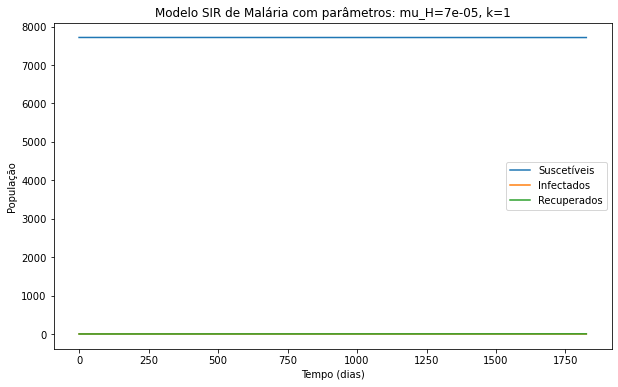

In [85]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(modelo_dinamica_pop, [0, 1825], [S_H0, I_H0, R_H0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title(f'Modelo SIR de Malária com parâmetros: mu_H={round(mu_H, 5)}, k={k}')

plt.legend()

plt.show()

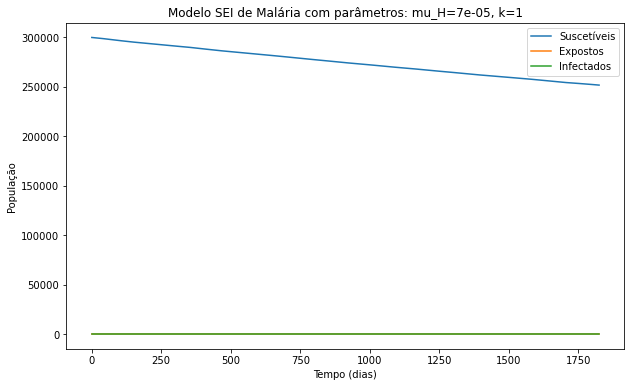

In [86]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(modelo_dinamica_pop, [0, 1825], [S_H0, I_H0, R_H0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title(f'Modelo SEI de Malária com parâmetros: mu_H={round(mu_H, 5)}, k={k}')

plt.legend()

plt.show()

In [87]:
k=2.0746963059512207

In [88]:
initial_R0_sir, initial_R0_sei, initial_R0_full, a0 = calculate_initial_values(R_L, T_linha, Tmin, DD, D1, 
                                                                               T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                               p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, 
                                                                               gamma, mu_H, k)

print(f'R0_sir = {initial_R0_sir} \nR0_sei = {initial_R0_sei}\nR0_acoplado = {initial_R0_full}\nTaxa de picadas = {a0}')

R0_sir = 0.535431783645363 
R0_sei = 1.8676515487962488
R0_acoplado = 1.0
Taxa de picadas = 0.02409676240499894


In [89]:
args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0, R_H0, mu_H, k)

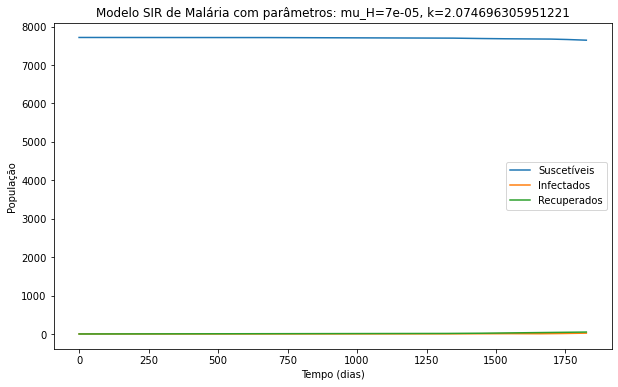

In [90]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(modelo_dinamica_pop, [0, 1825], [S_H0, I_H0, R_H0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title(f'Modelo SIR de Malária com parâmetros: mu_H={round(mu_H, 5)}, k={k}')

plt.legend()

plt.show()

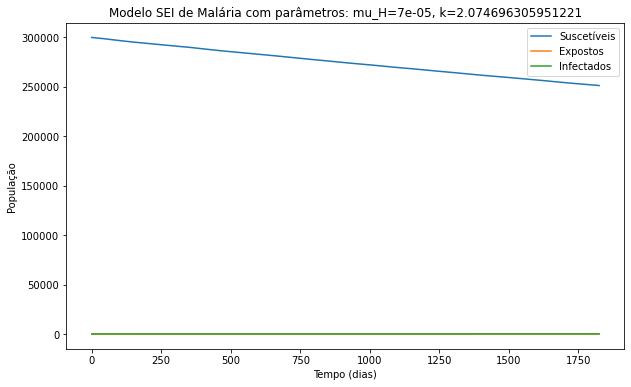

In [91]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(modelo_dinamica_pop, [0, 1825], [S_H0, I_H0, R_H0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title(f'Modelo SEI de Malária com parâmetros: mu_H={round(mu_H, 5)}, k={k}')

plt.legend()

plt.show()

In [92]:
k=2.5

In [93]:
initial_R0_sir, initial_R0_sei, initial_R0_full, a0 = calculate_initial_values(R_L, T_linha, Tmin, DD, D1, 
                                                                               T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                               p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, 
                                                                               gamma, mu_H, k)

print(f'R0_sir = {initial_R0_sir} \nR0_sei = {initial_R0_sei}\nR0_acoplado = {initial_R0_full}\nTaxa de picadas = {a0}')

R0_sir = 0.6451929640370601 
R0_sei = 2.25051197064232
R0_acoplado = 1.2049956385562577
Taxa de picadas = 0.02409676240499894


In [94]:
args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0, R_H0, mu_H, k)

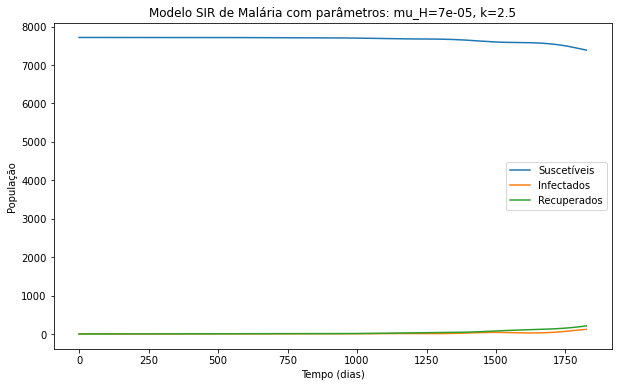

In [95]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(modelo_dinamica_pop, [0, 1825], [S_H0, I_H0, R_H0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title(f'Modelo SIR de Malária com parâmetros: mu_H={round(mu_H, 5)}, k={round(k, 2)}')

plt.legend()

plt.show()

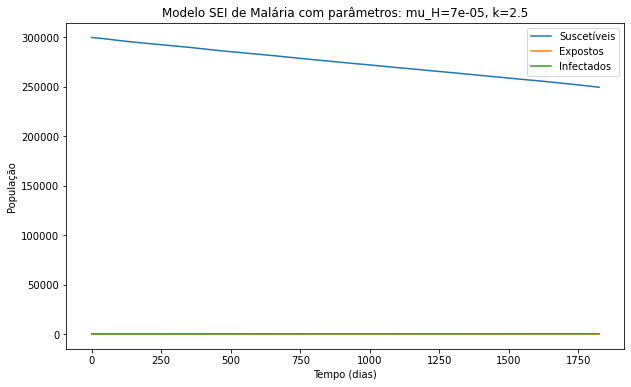

In [96]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(modelo_dinamica_pop, [0, 1825], [S_H0, I_H0, R_H0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title(f'Modelo SEI de Malária com parâmetros: mu_H={round(mu_H, 5)}, k={round(k, 2)}')

plt.legend()

plt.show()

In [97]:
k=5

In [98]:
initial_R0_sir, initial_R0_sei, initial_R0_full, a0 = calculate_initial_values(R_L, T_linha, Tmin, DD, D1, 
                                                                               T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                               p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, 
                                                                               gamma, mu_H, k)

print(f'R0_sir = {initial_R0_sir} \nR0_sei = {initial_R0_sei}\nR0_acoplado = {initial_R0_full}\nTaxa de picadas = {a0}')

R0_sir = 1.2903859280741201 
R0_sei = 4.50102394128464
R0_acoplado = 2.4099912771125154
Taxa de picadas = 0.02409676240499894


In [99]:
args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0, R_H0, mu_H, k)

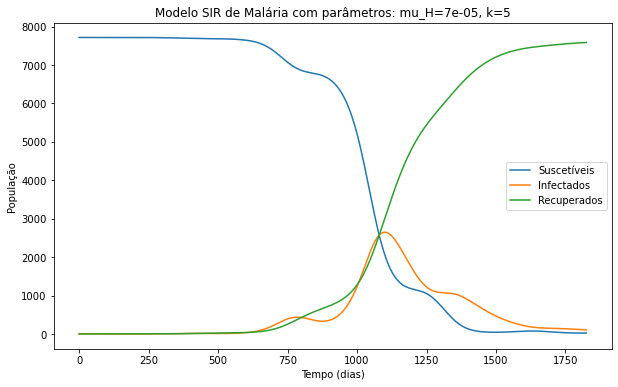

In [100]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(modelo_dinamica_pop, [0, 1825], [S_H0, I_H0, R_H0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title(f'Modelo SIR de Malária com parâmetros: mu_H={round(mu_H, 5)}, k={k}')

plt.legend()

plt.show()

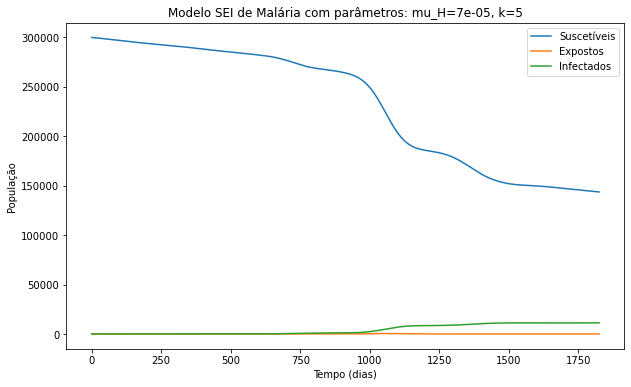

In [101]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(modelo_dinamica_pop, [0, 1825], [S_H0, I_H0, R_H0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title(f'Modelo SEI de Malária com parâmetros: mu_H={round(mu_H, 5)}, k={k}')

plt.legend()

plt.show()

In [102]:
k=10

In [103]:
initial_R0_sir, initial_R0_sei, initial_R0_full, a0 = calculate_initial_values(R_L, T_linha, Tmin, DD, D1, 
                                                                               T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                               p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, 
                                                                               gamma, mu_H, k)

print(f'R0_sir = {initial_R0_sir} \nR0_sei = {initial_R0_sei}\nR0_acoplado = {initial_R0_full}\nTaxa de picadas = {a0}')

R0_sir = 2.5807718561482402 
R0_sei = 9.00204788256928
R0_acoplado = 4.819982554225031
Taxa de picadas = 0.02409676240499894


In [104]:
args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0, R_H0, mu_H, k)

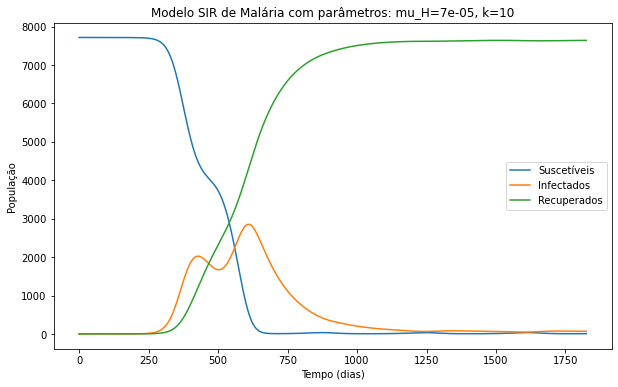

In [105]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(modelo_dinamica_pop, [0, 1825], [S_H0, I_H0, R_H0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title(f'Modelo SIR de Malária com parâmetros: mu_H={round(mu_H, 5)}, k={k}')

plt.legend()

plt.show()

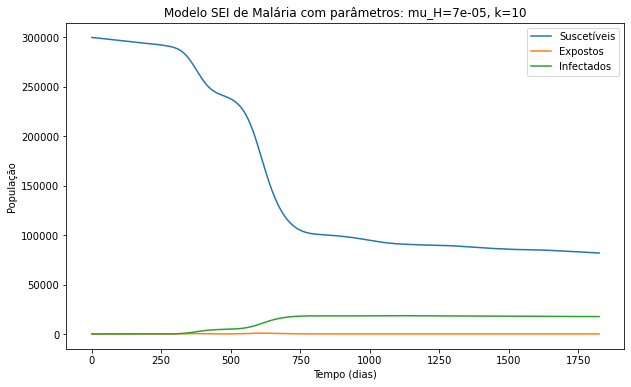

In [106]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(modelo_dinamica_pop, [0, 1825], [S_H0, I_H0, R_H0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title(f'Modelo SEI de Malária com parâmetros: mu_H={round(mu_H, 5)}, k={k}')

plt.legend()

plt.show()

## 16

#### Calculando $\mathcal{R}_0$, $S_H^*$ e $I_H^*$ em função de $k$:

#### $\mathcal{R}_0$:

In [107]:
def equation_to_solve(k):
    initial_R0_full = calculate_initial_values(
        R_L, T_linha, Tmin, DD, D1, T1, T2,
        omega1, phi1, R1, R2, omega2, phi2,
        p_ML, p_ME, p_MP, c1, c2, A, B, C,
        b1, b2, gamma, mu_H, k)[2] ##índice de R0 completo em calculate_initial_values
    return initial_R0_full -1

# Use fsolve to find the root (solution)
initial_guess = 0.5  # Choose an initial guess for k
k_solution = fsolve(equation_to_solve, initial_guess)

print(f"O valor de k que aproxima R0 de 1 é {k_solution[0]}")

O valor de k que aproxima R0 de 1 é 2.0746963059512207


In [108]:
k_values = np.linspace(0, 10, 100) 

R0_full_values = []

for k_val in k_values:
    initial_R0_sir, initial_R0_sei, R0_full_val, a0_val = calculate_initial_values(R_L, T_linha, Tmin, DD, D1, 
                                                                               T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                               p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, 
                                                                               gamma, mu_H, k=k_val)
    R0_full_values.append(R0_full_val)

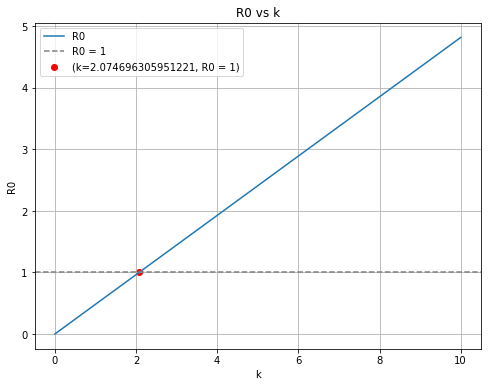

In [109]:
k_value_at_1 = 2.0746963059512207
R0_value_at_1 = 1

plt.figure(figsize=(8, 6))

plt.plot(k_values, R0_full_values, label='R0')
plt.scatter([k_value_at_1], [R0_value_at_1], color='red', label=f'(k={k_value_at_1}, R0 = {R0_value_at_1})')
plt.axhline(y=1, color='gray', linestyle='--', label='R0 = 1')
plt.xlabel('k')
plt.ylabel('R0')
plt.title('R0 vs k')
plt.legend()
plt.grid(True)
plt.show()

#### $I_H^*$:

In [110]:
def equilibrium_numerator_IH(N, mu, b3, l, mu_H, a, b, b1, b2, k, gamma):
    return (N**2 * mu**3 + (N**2 * b3 + N**2 * l)*mu**2)*mu_H**2 - (N * a**2 * b * b1 * b2 * b3 * k**2 - N**2 * gamma * mu**3 - (N**2 * b3 * gamma + N**2 * gamma * l) * mu**2) * mu_H
     
    
def equilibrium_denominator_IH(N, mu, b3, l, mu_H, a, b, b1, b2, k, gamma):
    return a**2 * b * b1 * b2 * b3 * gamma * k**2 + (N * a * b1 * k * mu**2 + (N * a * b1 * b3 * k + N * a * b1 * k * l)*mu)*mu_H**2 + (a**2 * b * b1 * b2 * b3 * k**2 + N * a * b1 * gamma * k * mu**2 + (N * a * b1 * b3 * gamma * k + N * a * b1 * gamma * k * l)*mu)*mu_H
    
    
def equilibrium_IH(N, mu, b3, l, mu_H, a, b, b1, b2, k, gamma):
    return -1*equilibrium_numerator_IH(N, mu, b3, l, mu_H, a, b, b1, b2, k, gamma) / equilibrium_denominator_IH(N, mu, b3, l, mu_H, a, b, b1, b2, k, gamma)
 
def calculate_equilibrium_final_values_IH(N, R_L, T_linha, Tmin, DD, D1, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                            p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, gamma, mu_H, k):
    
    Tf = T1 * (1 + T2 * cos(omega1 * 1825 - phi1))
    Rf = R1 * (1 + R2 * cos(omega2 * 1825 - phi2))

    tau_Lf = 1 / (c1 * Tf + c2)

    p_LTf = np.exp(-(c1 * Tf + c2))
    
    p_LRf = (4 * p_ML / R_L**2) * Rf * (max(1e-5, R_L - Rf))
    
    p_LRTf = p_LRf * p_LTf
    
    p_ERf = (4 * p_ME / R_L**2) * Rf * (max(1e-5, R_L - Rf))
    
    p_PRf = (4 * p_MP / R_L**2) * Rf * (max(1e-5, R_L - Rf))

    af = (max(1e-5, Tf - T_linha)) / D1
    bf = B_E * p_ERf * p_LRTf * p_PRf / (tau_E + tau_Lf + tau_P)

    tau_Mf = DD / (max(1e-5, Tf - Tmin))
    
    b3f =  1 / tau_Mf
    
    pf = np.exp(-1 / (A * Tf**2 + B * Tf + C))
    lf = pf ** tau_Mf

    muf = -log(pf)

    equilibrium_numerator_final_IH = equilibrium_numerator_IH(N, muf, b3f, lf, mu_H, af, bf, b1, b2, k, gamma)
    equilibrium_denominator_final_IH = equilibrium_denominator_IH(N, muf, b3f, lf, mu_H, af, bf, b1, b2, k, gamma)
    equilibrium_final_IH = equilibrium_IH(N, muf, b3f, lf, mu_H, af, bf, b1, b2, k, gamma)
    
    return equilibrium_numerator_final_IH, equilibrium_denominator_final_IH, equilibrium_final_IH    

In [111]:
def equation_to_solve_equilibrium_IH(k):
    equilibrium_final_IH = calculate_equilibrium_final_values_IH(
        N, R_L, T_linha, Tmin, DD, D1, T1, T2,
        omega1, phi1, R1, R2, omega2, phi2,
        p_ML, p_ME, p_MP, c1, c2, A, B, C,
        b1, b2, gamma, mu_H, k)[2] ##índice do equilíbrio completo em calculate_equilibrium_final_values
    return equilibrium_final_IH

# Use fsolve para achar a solução 
initial_guess = 0.5  # Escolha de um chute inicial de k
k_solution = fsolve(equation_to_solve_equilibrium_IH, initial_guess)

print(f"O valor de k que zera o equilíbrio é {k_solution[0]}")

O valor de k que zera o equilíbrio é 0.7948596924159165


In [112]:
k_values = np.linspace(2.0746963059512207, 10, 100) 

equilibrium_IH_full_values = []

for k_val in k_values:
    equilibrium_numerator_final_IH, equilibrium_denominator_final_IH, equilibrium_final_IH = calculate_equilibrium_final_values_IH(N, R_L, T_linha, Tmin, DD, D1, 
                                                                               T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                               p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, 
                                                                               gamma, mu_H, k=k_val)
    equilibrium_IH_full_values.append(equilibrium_final_IH)

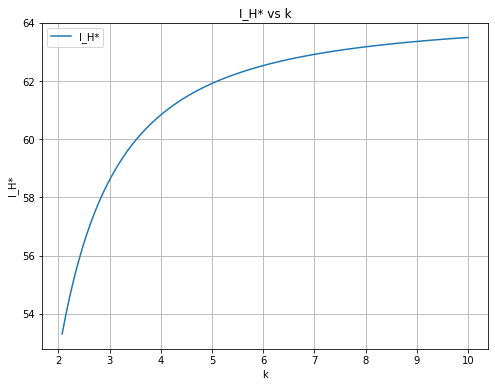

In [113]:
plt.figure(figsize=(8, 6))

plt.plot(k_values, equilibrium_IH_full_values, label='I_H*')
plt.xlabel('k')
plt.ylabel('I_H*')
plt.title('I_H* vs k')

plt.legend()
plt.grid(True)

plt.show() 

#### $S_H^*$:

In [114]:
def equilibrium_numerator_SH(N, mu, b3, l, mu_H, a, b, b1, b2, k, gamma):
    return N**2*gamma*mu**3 + (N**2*b3*gamma + N**2*gamma*l)*mu**2 + (N**2*mu**3 + (N**2*a*b1*k + N**2*b3 + N**2*l)*mu**2 + (N**2*a*b1*b3*k + N**2*a*b1*k*l)*mu)*mu_H
    
def equilibrium_denominator_SH(N, mu, b3, l, mu_H, a, b, b1, b2, k, gamma):
    return a**2*b*b1*b2*b3*k**2 + (N*a*b1*k*mu**2 + (N*a*b1*b3*k+N*a*b1*k*l)*mu)*mu_H
    
def equilibrium_SH(N, mu, b3, l, mu_H, a, b, b1, b2, k, gamma):
    return equilibrium_numerator_SH(N, mu, b3, l, mu_H, a, b, b1, b2, k, gamma) / equilibrium_denominator_SH(N, mu, b3, l, mu_H, a, b, b1, b2, k, gamma)

def calculate_equilibrium_final_values_SH(N, R_L, T_linha, Tmin, DD, D1, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                            p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, gamma, mu_H, k):
    
    Tf = T1 * (1 + T2 * cos(omega1 * 1825 - phi1))
    Rf = R1 * (1 + R2 * cos(omega2 * 1825 - phi2))

    tau_Lf = 1 / (c1 * Tf + c2)

    p_LTf = np.exp(-(c1 * Tf + c2))
    
    p_LRf = (4 * p_ML / R_L**2) * Rf * (max(1e-5, R_L - Rf))
    
    p_LRTf = p_LRf * p_LTf
    
    p_ERf = (4 * p_ME / R_L**2) * Rf * (max(1e-5, R_L - Rf))
    
    p_PRf = (4 * p_MP / R_L**2) * Rf * (max(1e-5, R_L - Rf))

    af = (max(1e-5, Tf - T_linha)) / D1
    bf = B_E * p_ERf * p_LRTf * p_PRf / (tau_E + tau_Lf + tau_P)

    tau_Mf = DD / (max(1e-5, Tf - Tmin))
    
    b3f =  1 / tau_Mf
    
    pf = np.exp(-1 / (A * Tf**2 + B * Tf + C))
    lf = pf ** tau_Mf

    muf = -log(pf)

    equilibrium_numerator_final_SH = equilibrium_numerator_SH(N, muf, b3f, lf, mu_H, af, bf, b1, b2, k, gamma)
    equilibrium_denominator_final_SH = equilibrium_denominator_SH(N, muf, b3f, lf, mu_H, af, bf, b1, b2, k, gamma)
    equilibrium_final_SH = equilibrium_SH(N, muf, b3f, lf, mu_H, af, bf, b1, b2, k, gamma)
    
    return equilibrium_numerator_final_SH, equilibrium_denominator_final_SH, equilibrium_final_SH

In [115]:
def equation_to_solve_equilibrium_SH(k):
    equilibrium_final_SH = calculate_equilibrium_final_values_SH(
        N, R_L, T_linha, Tmin, DD, D1, T1, T2,
        omega1, phi1, R1, R2, omega2, phi2,
        p_ML, p_ME, p_MP, c1, c2, A, B, C,
        b1, b2, gamma, mu_H, k)[2] ##índice do equilíbrio completo em calculate_equilibrium_final_values
    return equilibrium_final_SH

# Use fsolve para achar a solução 
initial_guess = 0.5  # Escolha de um chute inicial de k
k_solution = fsolve(equation_to_solve_equilibrium_SH, initial_guess)

print(f"O valor de k que zera o equilíbrio é {k_solution[0]}")

O valor de k que zera o equilíbrio é 8.909848607953834e+81


/opt/sagemath-9.2/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


In [116]:
k_values = np.linspace(2.0746963059512207, 10, 100) 

equilibrium_SH_full_values = []

for k_val in k_values:
    equilibrium_numerator_final_SH, equilibrium_denominator_final_SH, equilibrium_final_SH = calculate_equilibrium_final_values_SH(N, R_L, T_linha, Tmin, DD, D1, 
                                                                               T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                               p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, 
                                                                               gamma, mu_H, k=k_val)
    equilibrium_SH_full_values.append(equilibrium_final_SH)

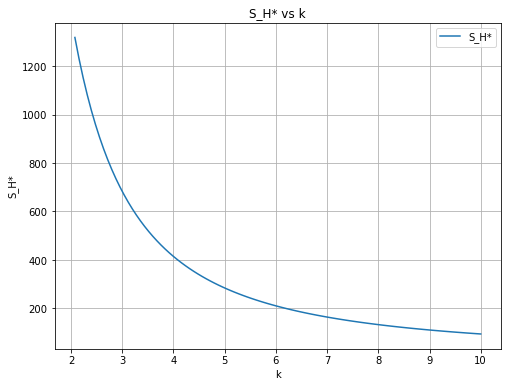

In [117]:
plt.figure(figsize=(8, 6))

plt.plot(k_values, equilibrium_SH_full_values, label='S_H*')
plt.xlabel('k')
plt.ylabel('S_H*')
plt.title('S_H* vs k')

plt.legend()
plt.grid(True)

plt.show() 